In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv("data/data_health/trace_activities.csv")

In [2]:
number_of_unique_activities = len(data["activity"].unique()) + 1

data["start"] = pd.to_datetime(data["start"])
data["end"] = pd.to_datetime(data["end"])

exclude_columns = [
    "traceId",
    "index",
    "activity",
    "start",
    "end",
    "EVENTID",
]

attributes = data.select_dtypes(
    include=["object", "category", "bool", "number"]
).columns.tolist()
selected_attributes = [attr for attr in attributes if attr not in exclude_columns]

In [3]:
# Identify attributes that do not vary within traces
def is_trace_level(attribute):
    return data.groupby('traceId')[attribute].nunique().max() == 1

# Filter out activity-level attributes
trace_level_attributes = [attr for attr in selected_attributes if is_trace_level(attr)]
trace_level_attributes

# Aggregate the selected trace-level attributes for each trace
trace_attributes = data.groupby("traceId")[trace_level_attributes].first().reset_index()

In [4]:
trace_durations = (
    data.groupby("traceId")
    .agg(start_time=("start", "min"), end_time=("end", "max"))
    .reset_index()
)

trace_durations["total_duration"] = (
    trace_durations["end_time"] - trace_durations["start_time"]
).dt.total_seconds()

trace_attributes = data.groupby("traceId")[selected_attributes].first().reset_index()
trace_data = trace_durations.merge(trace_attributes, on="traceId")
trace_data.head()

,traceId,start_time,end_time,total_duration,CORDERID,EINRI,ENDDT,LSSTAE,MANDT,NOTKZ,STATU,STORN
0,00035269-393b-47ca-9e77-6f9626433e4f,2023-08-25 16:40:00,2023-08-28 04:48:00,216480.0,False,Badajoz,Cerrado,ER,Doctor_10,False,70.0,Empty
1,00042ec6-0f5c-469f-bcf4-32ea9de63d5f,2023-08-26 14:59:00,2023-08-26 15:58:00,3540.0,False,Teruel,Cerrado,DI,Doctor_4,True,True,Empty
2,000811dc-2bdb-4497-96bc-0688b4bb381a,2023-08-28 02:16:00,2023-08-28 03:15:00,3540.0,False,Castellon,Cerrado,UA,Doctor_1,True,True,Empty
3,00132b96-1cac-4c27-80b2-ad3b59290d43,2023-08-31 08:00:00,2023-09-02 14:43:00,196980.0,True,Badajoz,Cerrado,ER,Doctor_10,False,60.0,Empty
4,0014f473-8b72-4ecd-95d2-b33762db32c2,2023-08-25 11:42:00,2023-08-25 13:41:00,7140.0,True,Badajoz,Cerrado,UA,Doctor_9,False,50.0,Empty


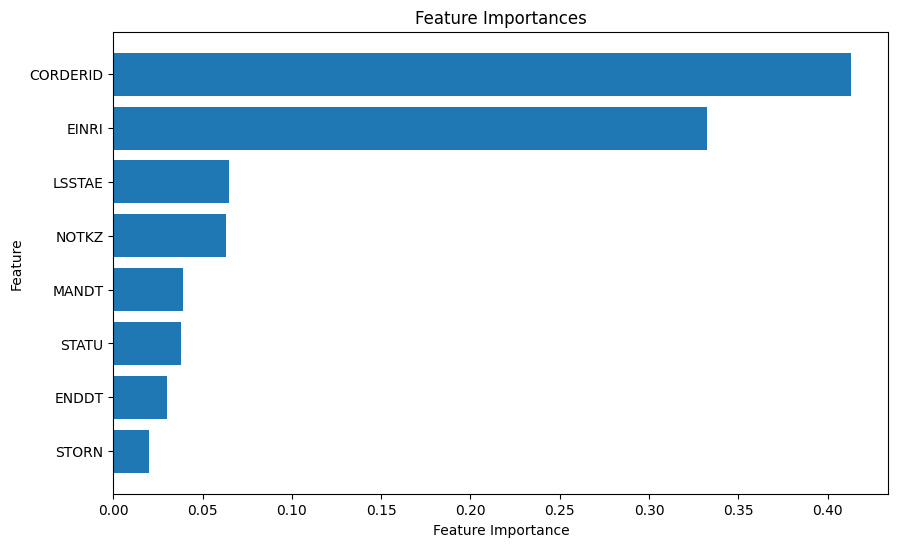

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in trace_data.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    trace_data[col] = le.fit_transform(trace_data[col])
    label_encoders[col] = le

X = trace_data.drop(columns=["traceId", "start_time", "end_time", "total_duration"])
y = trace_data["total_duration"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame(
    {"feature": X.columns, "importance": model.feature_importances_}
).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'].sort_values(ascending=True))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

In [6]:
threshold = 0.95
feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum()
selected_features = feature_importances[feature_importances['cumulative_importance'] <= threshold]['feature'].tolist()